In this dataset it will be to improve the V1


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report,precision_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
data = pd.read_csv('data\Tumeurs.csv')

In [3]:
y = data['label'].copy()
X = data.drop('label', axis=1).copy()
columns_X = X.columns

In [4]:
X = X/255

### Reduce to have the same size in dataset (Class 0, 2, 6 )

Before we have to compute to have the same size : 

In [5]:
data_to_reduce4 = data[data['label']== 4]

data_to_reduce4 = data_to_reduce4.sample(frac=0.015, replace=True, random_state=0)


data_to_reduce6 = data[data['label']== 6]
data_to_reduce6 = data_to_reduce6.sample(frac=0.091, replace=True, random_state=0)

data_to_reduce2 = data[data['label']== 2]
data_to_reduce2 = data_to_reduce2.sample(frac=0.091, replace=True, random_state=0)

data_to_reduce1 = data[data['label']== 1]
data_to_reduce1 = data_to_reduce1.sample(frac=0.2, replace=True, random_state=0)

data_to_reduce0 = data[data['label']== 0]
data_to_reduce0 = data_to_reduce0.sample(frac=0.33, replace=True, random_state=0)

data_to_reduce5 = data[data['label']== 5]
data_to_reduce3 = data[data['label']== 3]

data_stabled = pd.concat((data_to_reduce4, data_to_reduce6, data_to_reduce2, data_to_reduce1, data_to_reduce0, data_to_reduce5,data_to_reduce3))


In [6]:
from scipy import signal
from matplotlib.pyplot import imshow, get_cmap

In [7]:
def displayTwoBaWImages(img1, img2):
    _, axes = plt.subplots(ncols=2)
    axes[0].imshow(img1, cmap=plt.get_cmap('gray'))
    axes[1].imshow(img2, cmap=plt.get_cmap('gray'))

kernel_inccontrast = np.array([[0,0,0,0,0], 
                               [0,0,-1,0,0], 
                               [0,-1,5,-1,0], 
                               [0,0,-1,0,0], 
                               [0,0,0,0,0]])

In [8]:
def preprocessing_data_convolution(data) : 

    X_convolved = []

    #1. Separate the dataset
    y = data['label'].copy()
    print(np.array(y).shape)
    X = data.drop('label', axis=1).copy()
    X = X/255
    X = np.array(X)
    #2. Loop to convolve each images. 
    for image in range(0, len(data)) : 
        image_test = np.array(X[image]).reshape(28,28)
        image_conv  = signal.wiener(image_test, (5,5))
        
        X_convolved.append(image_conv)
        #print(np.array(X_convolved).shape)
        #plt.imshow(image_test, cmap = 'gray')
    return np.array(X_convolved)

result = preprocessing_data_convolution(data_stabled)


(770,)


In [9]:
y = data_stabled['label'].copy()
X = data_stabled.drop('label', axis=1).copy()
y.value_counts()


5    142
3    115
0    108
1    103
4    101
6    101
2    100
Name: label, dtype: int64

In [10]:
columns_X = X.columns

In [11]:
data_stabled.to_csv('data\Tumeurs_data_stabled.csv')



The data is stable. Let's create our NN 

In [12]:

X = np.array(X)
X = X.reshape(770 ,28,28,1)

#X = X.reshape(len(data_stabled),784)

#Scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)


Callback 

In [13]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [35]:
model =tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu" , input_shape = (28, 28, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") , 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(rate = 0.15), #Important parameter

    tf.keras.layers.Dense(units = 256, activation = 'relu'), 

    tf.keras.layers.Dense(units = 64, activation = 'relu'), 
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(), #Convert 3d in 2d features vectors 
 
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(7,activation = "softmax")])


In [36]:
model.summary()
tf.keras.utils.plot_model(model)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,callbacks = [early], validation_data=(X_val, y_val))
#history = model.fit(X_train, y_train, epochs=100,callbacks = [early])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 128)        

c:\Users\mathi\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


16/16 [==============================] - 1s 27ms/step - loss: 2.4616 - accuracy: 0.1608 - val_loss: 5.4059 - val_accuracy: 0.1111
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 2.1662 - accuracy: 0.2062 - val_loss: 7.0215 - val_accuracy: 0.1852
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 1.9906 - accuracy: 0.2371 - val_loss: 6.2894 - val_accuracy: 0.2037
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 1.9634 - accuracy: 0.2639 - val_loss: 4.5912 - val_accuracy: 0.1667
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 1.9631 - accuracy: 0.2474 - val_loss: 2.7457 - val_accuracy: 0.2222
Epoch 6/100
16/16 [==============================] - 0s 17ms/step - loss: 1.9110 - accuracy: 0.2557 - val_loss: 2.9193 - val_accuracy: 0.1667
Epoch 7/100
16/16 [==============================] - 0s 18ms/step - loss: 1.8912 - accuracy: 0.2742 - val_loss: 2.0991 - val_accuracy: 0.2222
Epoch 8/100
16/16 

In [37]:
tf.keras.utils.plot_model(model)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [38]:
model_acc = model.evaluate(X_test, y_test)[1]

print("Test Accuracy: {:.3f}%".format(model_acc * 100))

8/8 [==============================] - 0s 5ms/step - loss: 1.7809 - accuracy: 0.2771
Test Accuracy: 27.706%


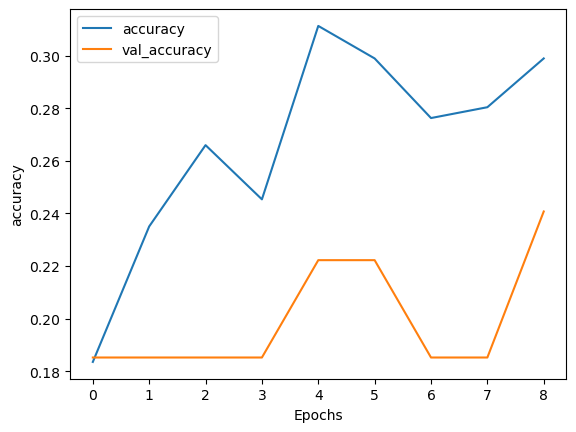

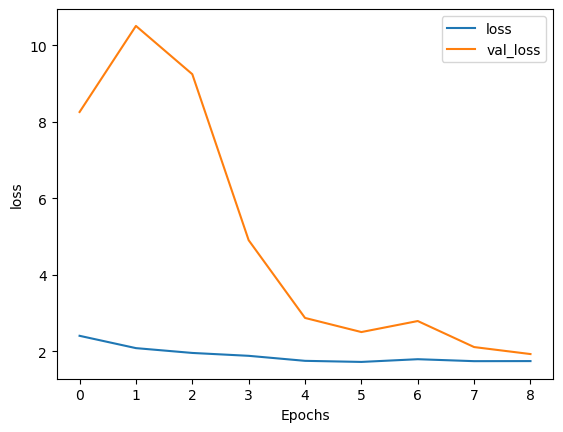

In [33]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The data is too unstable 

In [39]:
y_true = np.array(y_test)

label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())

In [40]:
y.value_counts()

5    142
3    115
0    108
1    103
4    101
6    101
2    100
Name: label, dtype: int64

              precision    recall  f1-score   support

           0       0.56      0.33      0.42        30
           1       1.00      0.03      0.07        29
           2       0.25      0.52      0.34        27
           3       0.00      0.00      0.00        37
           4       0.22      0.94      0.36        34
           5       0.60      0.07      0.12        44
           6       0.50      0.13      0.21        30

    accuracy                           0.28       231
   macro avg       0.45      0.29      0.22       231
weighted avg       0.44      0.28      0.21       231



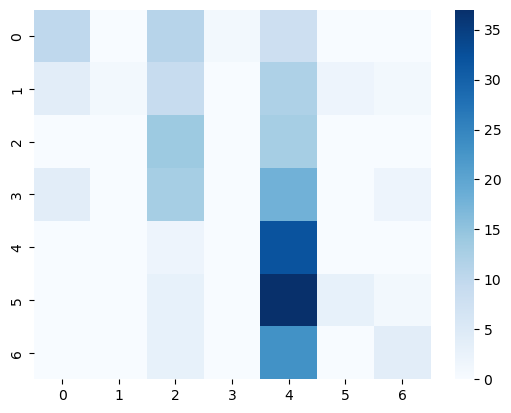

In [41]:

import seaborn as sn

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
cr2 = classification_report(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, cmap='Blues')
print(cr2)
#print(cm) 

In [42]:
#Cross validation

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 

X = np.array(X)

X = X.reshape(len(X),784)

lr = LogisticRegression(C =  10.0, penalty =  'l2')


scores = cross_val_score(lr, X, y, cv=5)

c:\Users\mathi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [43]:
scores

array([0.29220779, 0.28571429, 0.30519481, 0.32467532, 0.24675325])

### The class 3, 5 and 6 are well predicted : let's take the train and augmented it to at least reach the 50 in macro avg 

In [57]:
data = pd.read_csv('data\Tumeurs_data_augmented.csv')
data = data.drop('Unnamed: 0', axis = 1)
y = data['label'].copy()
X = data.drop('label', axis=1).copy()

X = np.array(X)
X = X.reshape(len(X) ,28,28,1)

#X = X.reshape(len(data_stabled),784)

#Scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)


In [58]:
X_train = pd.DataFrame(np.array(X_train).reshape(len(X_train), 784), columns = columns_X )
y_train = pd.DataFrame(np.array(y_train).reshape(len(y_train), 1), columns = ['label'])
new_data_train = pd.concat((X_train, y_train), axis = 1)


That's better.. Really We have our dataset 

In [59]:
data_to_replace2 = data[data['label']== 2]
data_to_replace2 = data_to_replace2.sample(frac=0.55, replace=True, random_state=0)

data_to_replace1 = data[data['label']== 1]
data_to_replace1 = data_to_replace1.sample(frac=0.2, replace=True, random_state=0)

data_to_replace6 = data[data['label']== 6]
data_to_replace6 = data_to_replace6.sample(frac=0.5, replace=True, random_state=0)


In [60]:
new_data_train.drop( new_data_train[ new_data_train['label'] == 2 ].index, inplace=True)
new_data_train.drop( new_data_train[ new_data_train['label'] == 1 ].index, inplace=True)
new_data_train.drop( new_data_train[ new_data_train['label'] == 6 ].index, inplace=True)


In [61]:
new_data_train

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,186,185,181,176,178,184,182,185,191,180,...,195,185,185,180,183,188,187,185,181,5
2,135,138,144,144,144,140,141,147,145,145,...,144,143,145,146,145,136,134,134,137,4
3,202,207,199,200,209,208,189,189,199,210,...,200,198,197,185,180,189,195,192,181,5
4,124,129,117,100,112,117,124,130,120,117,...,123,125,122,107,100,95,69,83,75,0
5,147,148,151,153,155,157,158,158,157,150,...,147,152,153,152,150,150,148,146,144,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,125,136,124,143,152,134,147,153,153,155,...,189,178,176,171,173,167,164,158,156,0
172,116,123,133,132,135,142,140,142,150,149,...,149,147,146,149,145,141,141,141,142,5
173,20,71,122,135,142,144,142,145,150,150,...,63,37,41,54,45,57,57,42,29,4
174,146,146,131,137,157,160,145,161,163,159,...,161,169,170,161,164,157,147,146,144,3


In [62]:
y.value_counts()

5    55
6    50
0    42
4    42
3    42
2    28
1    21
Name: label, dtype: int64

In [63]:
data_train_replaced = pd.concat((data_to_replace2, data_to_replace1, data_to_replace6,new_data_train))

In [64]:
data_train_replaced
y.value_counts()


5    55
6    50
0    42
4    42
3    42
2    28
1    21
Name: label, dtype: int64

In [65]:
data_train_replaced = data_train_replaced.reset_index()
data_train_replaced = data_train_replaced.drop('index', axis = 1)
#data_train_replaced = data_train_replaced.drop('level_0', axis = 1)

In [66]:
data_train_replaced

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,13,22,24,23,18,34,59,71,98,119,...,90,43,16,16,18,15,7,0,0,2
1,161,170,175,177,178,177,180,179,181,185,...,153,147,142,140,151,149,143,143,137,2
2,98,100,103,96,104,133,142,139,135,142,...,171,170,171,159,168,165,149,138,131,2
3,125,141,148,150,145,147,146,144,147,152,...,148,149,148,147,146,136,116,85,42,2
4,140,148,151,150,153,150,158,157,155,150,...,156,157,157,152,146,141,139,133,136,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,125,136,124,143,152,134,147,153,153,155,...,189,178,176,171,173,167,164,158,156,0
152,116,123,133,132,135,142,140,142,150,149,...,149,147,146,149,145,141,141,141,142,5
153,20,71,122,135,142,144,142,145,150,150,...,63,37,41,54,45,57,57,42,29,4
154,146,146,131,137,157,160,145,161,163,159,...,161,169,170,161,164,157,147,146,144,3


In [71]:
X = np.array(X)
X = X.reshape(len(data) ,28,28,1)
#Scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [72]:
model =tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu" , input_shape = (28, 28, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") , 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(rate = 0.15), #Important parameter

    tf.keras.layers.Dense(units = 256, activation = 'relu'), 

    tf.keras.layers.Dense(units = 64, activation = 'relu'), 
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(), #Convert 3d in 2d features vectors 
 
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(7,activation = "softmax")])
model.summary()
tf.keras.utils.plot_model(model)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,callbacks = [early], validation_data=(X_val, y_val))
#history = model.fit(X_train, y_train, epochs=100,callbacks = [early])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 1, 128)        

c:\Users\mathi\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


6/6 [==============================] - 1s 42ms/step - loss: 2.6247 - accuracy: 0.2216 - val_loss: 5.5608 - val_accuracy: 0.2000
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 2.3976 - accuracy: 0.2443 - val_loss: 4.5700 - val_accuracy: 0.2000
Epoch 3/100
6/6 [==============================] - 0s 19ms/step - loss: 2.2490 - accuracy: 0.2386 - val_loss: 4.1387 - val_accuracy: 0.1500
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 2.1053 - accuracy: 0.2500 - val_loss: 6.5340 - val_accuracy: 0.1500
Epoch 5/100
6/6 [==============================] - 0s 18ms/step - loss: 1.8919 - accuracy: 0.2784 - val_loss: 6.6987 - val_accuracy: 0.1500
Epoch 6/100
6/6 [==============================] - 0s 19ms/step - loss: 1.8856 - accuracy: 0.2955 - val_loss: 7.3741 - val_accuracy: 0.1500
Epoch 7/100
6/6 [==============================] - 0s 19ms/step - loss: 1.6621 - accuracy: 0.3580 - val_loss: 6.8268 - val_accuracy: 0.1500
Epoch 8/100
6/6 [===============

              precision    recall  f1-score   support

           0       0.25      0.33      0.29        15
           1       1.00      0.33      0.50         6
           2       0.57      0.44      0.50         9
           3       0.30      0.67      0.41        12
           4       0.43      0.55      0.48        11
           5       0.75      0.16      0.26        19
           6       0.60      0.50      0.55        12

    accuracy                           0.40        84
   macro avg       0.56      0.43      0.43        84
weighted avg       0.53      0.40      0.40        84



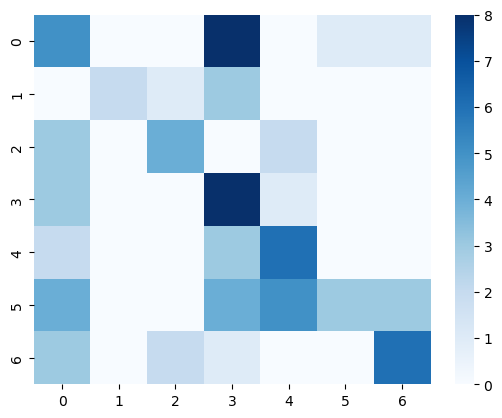

In [73]:
y_true = np.array(y_test)

label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
import seaborn as sn

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
cr2 = classification_report(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, cmap='Blues')
print(cr2)
#print(cm) 

This one is really good ! Let's save it 

from files.CNN import cnn